In [113]:
import os

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from scipy.stats import friedmanchisquare

import seaborn as sns

from time import time

from tqdm import tqdm

import pickle
import json

# Clustering

In [2]:
K = list(range(2, 10))

In [3]:
df = pd.read_csv(r'./df_tfidf4395.csv')
df.head()

,act,afraid,age,ago,ah,ai,aint,air,aliv,alon,...,x2,ya,ye,yea,yeah,year,yesterday,yo,young,index
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.028271,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0
1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1
2,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.085668,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,2
3,0.0,0.0,0.0,0.0,0.0,0.03901,0.0,0.254412,0.000000,0.000000,...,0.0,0.0,0.100178,0.0,0.035947,0.188197,0.0,0.0,0.027036,3
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.216461,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,4


In [4]:
features = df.columns.tolist()[:-1]

In [5]:
data = df[features].values

## Kmeans

In [6]:
results = {}
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=905).fit(data)
    labels = kmeans.labels_
    results[k] = {
                  'db_index': davies_bouldin_score(data, labels),
                  'labels': kmeans.labels_,
                  'centres': kmeans.cluster_centers_
                 }
    print(k, davies_bouldin_score(data, labels))

2 8.5776640097168
3 7.602568532441171
4 6.5123734239046405
5 7.860200282523778
6 7.593222031160148
7 7.236792062867887
8 6.571751734390039
9 6.643355777503522


## LDA

In [7]:
n_top_words = 20

In [8]:
lda = LatentDirichletAllocation(n_components=4, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=905)

In [9]:
t0 = time()
lda.fit(data)
print("done in %0.3fs." % (time() - t0))

done in 2.418s.


In [10]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [11]:
print_top_words(lda, features, n_top_words)

Topic #0: la holi da shall prais glori mr bore lord king hi born power chain fame lil luck ooh sing high
Topic #1: dem doll di wild escap lone choru quick check like war say bout heart want deep day man come da
Topic #2: thou brown touch suck hot gold kill burn great fuck murder bag woah feel tree love bird deeper need wit
Topic #3: love know like got ll time ve oh come want na let say feel make way babi ca day life



# Classification

## Data preparing

In [12]:
with open(r'./lyrics_emotion[0-7480].json', 'r') as fn:
    emo_dict = json.load(fn)

In [13]:
data_cls = pd.read_csv('./df_4395.csv')
data_cls.head()

,index,song,year,artist,genre,lyrics,word_count,represent,represent_2nd,word_count_2nd
0,0,louder-flux-pavilion-doctor-p-remix,2012,dj-fresh,Electronic,I can't control this feeling Something's happe...,341.0,I ca n't control feel someth 's happen insid o...,I ca n't control feel someth 's happen insid s...,339
1,1,that-s-my-name,2009,akcent,Pop,In my heart I will keep you In my heart Foreve...,318.0,In heart I keep In heart forev In heart and on...,In heart I keep In heart forev In heart one li...,169
2,2,lemonade,2007,apologetix,Rock,"Oh, Mama, I've been cleared of my crimes and I...",250.0,Oh mama I 've clear crime I 'm law law put end...,Oh mama I 've clear crime I 'm law law put end...,119
3,3,return-of-the-hustle,2007,fabolous,Hip-Hop,Record mode! (Record mode!) Get your money in ...,681.0,record mode record mode get money air like yea...,record record get money air like yeah yeah tim...,338
4,4,so-sad,1974,george-harrison,Rock,Now the winter has come To eclipse out the sun...,163.0,now winter come To eclips sun that light love ...,winter come To sun light love sometim cold win...,72


In [14]:
data_cls['clustered_label'] = pd.Series(results[4]['labels'])
data_cls.head()

,index,song,year,artist,genre,lyrics,word_count,represent,represent_2nd,word_count_2nd,clustered_label
0,0,louder-flux-pavilion-doctor-p-remix,2012,dj-fresh,Electronic,I can't control this feeling Something's happe...,341.0,I ca n't control feel someth 's happen insid o...,I ca n't control feel someth 's happen insid s...,339,3
1,1,that-s-my-name,2009,akcent,Pop,In my heart I will keep you In my heart Foreve...,318.0,In heart I keep In heart forev In heart and on...,In heart I keep In heart forev In heart one li...,169,2
2,2,lemonade,2007,apologetix,Rock,"Oh, Mama, I've been cleared of my crimes and I...",250.0,Oh mama I 've clear crime I 'm law law put end...,Oh mama I 've clear crime I 'm law law put end...,119,2
3,3,return-of-the-hustle,2007,fabolous,Hip-Hop,Record mode! (Record mode!) Get your money in ...,681.0,record mode record mode get money air like yea...,record record get money air like yeah yeah tim...,338,0
4,4,so-sad,1974,george-harrison,Rock,Now the winter has come To eclipse out the sun...,163.0,now winter come To eclips sun that light love ...,winter come To sun light love sometim cold win...,72,1


In [15]:
emotions = ['Fear',
            'Sad',
            'Bored',
            'Happy',
            'Excited',
            'Angry']

In [16]:
for e in tqdm(emotions):
    data_cls[e] = np.nan

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1002.66it/s]


In [17]:
for i in tqdm(range(len(data_cls))):
    lyrics_emotion = emo_dict[str(i)]['emotion']
    values = [lyrics_emotion[e] for e in emotions]
    data_cls.at[i, emotions] = values
#     break

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4395/4395 [00:06<00:00, 663.21it/s]


# Analysis

In [107]:
data_ana = pd.read_csv('./df_4395.csv')
data_ana.head()

,index,song,year,artist,genre,lyrics,word_count,represent,represent_2nd,word_count_2nd
0,0,louder-flux-pavilion-doctor-p-remix,2012,dj-fresh,Electronic,I can't control this feeling Something's happe...,341.0,I ca n't control feel someth 's happen insid o...,I ca n't control feel someth 's happen insid s...,339
1,1,that-s-my-name,2009,akcent,Pop,In my heart I will keep you In my heart Foreve...,318.0,In heart I keep In heart forev In heart and on...,In heart I keep In heart forev In heart one li...,169
2,2,lemonade,2007,apologetix,Rock,"Oh, Mama, I've been cleared of my crimes and I...",250.0,Oh mama I 've clear crime I 'm law law put end...,Oh mama I 've clear crime I 'm law law put end...,119
3,3,return-of-the-hustle,2007,fabolous,Hip-Hop,Record mode! (Record mode!) Get your money in ...,681.0,record mode record mode get money air like yea...,record record get money air like yeah yeah tim...,338
4,4,so-sad,1974,george-harrison,Rock,Now the winter has come To eclipse out the sun...,163.0,now winter come To eclips sun that light love ...,winter come To sun light love sometim cold win...,72


In [108]:
data_ana['genre'].value_counts()

Rock             1840
Pop               657
Hip-Hop           472
Metal             368
Not Available     325
Country           283
Electronic        135
Jazz              110
R&B                67
Other              60
Indie              54
Folk               24
Name: genre, dtype: int64

In [109]:
data_ana = data_ana.replace({'\n': ' '}, regex=True)

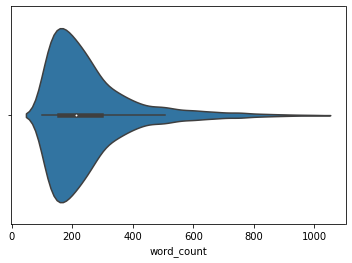

In [115]:
data_ana['word_count'] = data_ana['lyrics'].str.split().str.len()
sns.violinplot(x=data_ana["word_count"])

## Modeling

### Measures

In [18]:
def measures(ypred, ytest):
    return f1_score(ypred, ytest, average='micro'), cohen_kappa_score(ypred, ytest)

kappa_scorer = make_scorer(cohen_kappa_score)

scoring = kappa_scorer

### SVM

In [54]:
def svm_model(xtrain, xtest, ytrain, ytest, batch):
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 
                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
    clf = GridSearchCV(
        SVC(), 
        param_grid, 
        scoring=scoring, 
        n_jobs=-1, 
        cv=10
    )
    searcher = clf.fit(xtrain, ytrain)
    estimator = searcher.best_estimator_
    f1, kappa = measures(estimator.predict(xtest), ytest)
    print('[SVM] training: ', 'f1:', f1, 'kappa:', kappa, "done in %0.3fs." % (time() - t0))
    with open(batch + '_svm_clf.pickle', 'wb') as f:
        pickle.dump(clf, f)
    with open(batch + '_svm_searcher.pickle',
              'wb') as sf:
        pickle.dump(searcher, sf)
    with open(batch + '_svm_estimator.pickle',
      'wb') as sfm:
        pickle.dump(estimator, sfm)
    return searcher, estimator, clf, f1, kappa

### Logistic Regression

In [55]:
def lg_model(xtrain, xtest, ytrain, ytest, batch):
    t0 = time()
    param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
                  'max_iter': range(10, 50, 10)}
    clf = GridSearchCV(
                        LogisticRegression(multi_class='auto', n_jobs=-1), 
                        param_grid, 
                        scoring=scoring,
                        n_jobs=-1, 
                        cv=10
                      )
    searcher = clf.fit(xtrain, ytrain)
    estimator = searcher.best_estimator_
    f1, kappa = measures(estimator.predict(xtest), ytest)
    print('[LG] training: ', 'f1:', f1, 'kappa:', kappa, "done in %0.3fs." % (time() - t0))
    with open(batch + '_lg_clf.pickle', 'wb') as f:
        pickle.dump(clf, f)
    with open(batch + '_lg_searcher.pickle',
              'wb') as sf:
        pickle.dump(searcher, sf)
    with open(batch + '_lg_estimator.pickle',
      'wb') as sfm:
        pickle.dump(estimator, sfm)
    return searcher, estimator, clf, f1, kappa

### Decision Tree

In [56]:
def dt_model(xtrain, xtest, ytrain, ytest, batch):
    t0 = time()
    param_grid = {'min_samples_split': range(2, 403, 20)}
    clf = GridSearchCV(
        tree.DecisionTreeClassifier(), param_grid, scoring=scoring,
                        n_jobs=-1, 
                        cv=10
    )
    searcher = clf.fit(xtrain, ytrain)
    estimator = searcher.best_estimator_
    f1, kappa = measures(estimator.predict(xtest), ytest)
    print('[dt] training: ', 'f1:', f1, 'kappa:', kappa, "done in %0.3fs." % (time() - t0))
    with open(batch + '_dt_clf.pickle', 'wb') as f:
        pickle.dump(clf, f)
    with open(batch + '_dt_searcher.pickle',
              'wb') as sf:
        pickle.dump(searcher, sf)
    with open(batch + '_dt_estimator.pickle',
      'wb') as sfm:
        pickle.dump(estimator, sfm)
    return searcher, estimator, clf, f1, kappa

### Naive Bayes

In [57]:
def nb_model(xtrain, xtest, ytrain, ytest, batch):
    t0 = time()
    param_grid = {}
    clf = GridSearchCV(GaussianNB(), param_grid,
                        n_jobs=-1, 
                        cv=10)
    searcher = clf.fit(xtrain, ytrain)
    estimator = searcher.best_estimator_
    f1, kappa = measures(estimator.predict(xtest), ytest)
    print('[NB] training: ', 'f1:', f1, 'kappa:', kappa, "done in %0.3fs." % (time() - t0))
    with open(batch + '_nb_clf.pickle', 'wb') as f:
        pickle.dump(clf, f)
    with open(batch + '_nb_searcher.pickle',
              'wb') as sf:
        pickle.dump(searcher, sf)
    with open(batch + '_nb_estimator.pickle',
      'wb') as sfm:
        pickle.dump(estimator, sfm)
    return searcher, estimator, clf, f1, kappa

### NN

In [58]:
def nn_model(xtrain, xtest, ytrain, ytest, batch):
    t0 = time()
    hidden_layer_sizes = (10, 50, 50, 10)
    param_grid = {
                  'alpha': [1e-5, 1e-4, 1e-3],
                  'solver': ['lbfgs', 'sgd', 'adam'],
                  'activation': ['identity', 'logistic', 'tanh', 'relu'],
                 }
    if batch == 'lyrics':
        hidden_layer_sizes=(100, 200, 100, 50)
    clf = GridSearchCV(MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, random_state=905, early_stopping=True), param_grid,
                        n_jobs=-1, 
                        cv=10)
    searcher = clf.fit(xtrain, ytrain)
    estimator = searcher.best_estimator_
    f1, kappa = measures(estimator.predict(xtest), ytest)
    print('[nn] training: ', 'f1:', f1, 'kappa:', kappa, "done in %0.3fs." % (time() - t0))
    with open(batch + '_nn_clf.pickle', 'wb') as f:
        pickle.dump(clf, f)
    with open(batch + '_nn_searcher.pickle',
              'wb') as sf:
        pickle.dump(searcher, sf)
    with open(batch + '_nn_estimator.pickle',
      'wb') as sfm:
        pickle.dump(estimator, sfm)
    return searcher, estimator, clf, f1, kappa

## Data spliting

In [24]:
data_cls['genre'].value_counts()

Rock             1840
Pop               657
Hip-Hop           472
Metal             368
Not Available     325
Country           283
Electronic        135
Jazz              110
R&B                67
Other              60
Indie              54
Folk               24
Name: genre, dtype: int64

In [25]:
target = {}
count = 1
for i in set(data_cls['genre'].tolist()):
    target[i] = count
    count += 1

In [26]:
target

{'Folk': 1,
 'Pop': 2,
 'Country': 3,
 'Other': 4,
 'Electronic': 5,
 'Jazz': 6,
 'Hip-Hop': 7,
 'Indie': 8,
 'Not Available': 9,
 'Metal': 10,
 'R&B': 11,
 'Rock': 12}

In [27]:
data_cls['genre_'] = data_cls['genre']

data_cls['genre'] = data_cls['genre'].map(target)

In [28]:
data_cls.columns

Index(['index', 'song', 'year', 'artist', 'genre', 'lyrics', 'word_count',
       'represent', 'represent_2nd', 'word_count_2nd', 'clustered_label',
       'Fear', 'Sad', 'Bored', 'Happy', 'Excited', 'Angry', 'genre_'],
      dtype='object')

# Training

## Emotion & Topic

In [29]:
X = data_cls[['clustered_label','Fear', 'Sad', 'Bored', 'Happy', 'Excited', 'Angry']].values
Y = data_cls['genre'].astype(int).values

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=31)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((3516, 7), (879, 7), (3516,), (879,))

In [59]:
# nn_searcher, nn_estimator, nn_clf, nn_f1, nn_kappa = nn_model(xtrain, xtest, ytrain, ytest, batch='Combined')
# svm_searcher, svm_estimator, svm_clf, svm_f1, svm_kappa = svm_model(xtrain, xtest, ytrain, ytest, batch='Combined')
lg_searcher, lg_estimator, lg_clf, lg_f1, lg_kappa = lg_model(xtrain, xtest, ytrain, ytest, batch='Combined')
dt_searcher, dt_estimator, dt_clf, dt_f1, dt_kappa = dt_model(xtrain, xtest, ytrain, ytest, batch='Combined')
nb_searcher, nb_estimator, nb_clf, nb_f1, nb_kappa = nb_model(xtrain, xtest, ytrain, ytest, batch='Combined')

[LG] training:  f1: 0.4641638225255973 kappa: 0.15662068923370254 done in 2.511s.
[dt] training:  f1: 0.44141069397042093 kappa: 0.15150270027975965 done in 0.997s.
[NB] training:  f1: 0.43913538111490324 kappa: 0.1412426355621348 done in 0.030s.


### Lyrics

In [31]:
X_ = data
Y_ = data_cls['genre'].astype(int).values

xtrain_, xtest_, ytrain_, ytest_ = train_test_split(X_, Y_, test_size=0.2, random_state=31)
xtrain_.shape, xtest_.shape, ytrain_.shape, ytest_.shape

((3516, 788), (879, 788), (3516,), (879,))

In [60]:
# nn_searcher_, nn_estimator_, nn_clf_, nn_f1_, nn_kappa_ = nn_model(xtrain_, xtest_, ytrain_, ytest_, batch='lyrics')
# svm_searcher_, svm_estimator_, svm_clf_, svm_f1_, svm_kappa_ = svm_model(xtrain_, xtest_, ytrain_, ytest_, batch='lyrics')
lg_searcher_, lg_estimator_, lg_clf_, lg_f1_, lg_kappa_ = lg_model(xtrain_, xtest_, ytrain_, ytest_, batch='lyrics')
dt_searcher_, dt_estimator_, dt_clf_, dt_f1_, dt_kappa_ = dt_model(xtrain_, xtest_, ytrain_, ytest_, batch='lyrics')
nb_searcher_, nb_estimator_, nb_clf_, nb_f1_, nb_kappa_ = nb_model(xtrain_, xtest_, ytrain_, ytest_, batch='lyrics')

[LG] training:  f1: 0.5164960182025028 kappa: 0.2754150252826477 done in 5.431s.
[dt] training:  f1: 0.41751990898748575 kappa: 0.19050436991083908 done in 50.816s.
[NB] training:  f1: 0.24118316268486917 kappa: 0.13869231865385823 done in 0.676s.


# Test

In [69]:
def load_models(path):
    models = {}
    for root, dirs, files in os.walk(path):
        for fn in files:
            eachpath = str(root+'/'+fn)
            if '.pickle' in eachpath and 'estimator' in eachpath:
                print(eachpath)
                models[fn.replace('.pickle', '')] = pickle.load(open(eachpath, 'rb'))
    return models

In [70]:
models_path = r'./'
models = load_models(models_path)
models.keys()

.//Combined_dt_estimator.pickle
.//Combined_lg_estimator.pickle
.//Combined_nb_estimator.pickle
.//lyrics_dt_estimator.pickle
.//lyrics_lg_estimator.pickle
.//lyrics_nb_estimator.pickle


dict_keys(['Combined_dt_estimator', 'Combined_lg_estimator', 'Combined_nb_estimator', 'lyrics_dt_estimator', 'lyrics_lg_estimator', 'lyrics_nb_estimator'])

In [71]:
evaluate_results = pd.DataFrame(columns=['group_model_k', 'f1', 'kappa'])
models_10fold = []
for model in list(models.keys()):
    for i in range(1, 11):
        model_i = model + '_' + str(i)
        models_10fold.append(model_i)
evaluate_results['group_model_k'] = pd.Series(list(models_10fold))
evaluate_results.head()

,group_model_k,f1,kappa
0,Combined_dt_estimator_1,NaN,NaN
1,Combined_dt_estimator_2,NaN,NaN
2,Combined_dt_estimator_3,NaN,NaN
3,Combined_dt_estimator_4,NaN,NaN
4,Combined_dt_estimator_5,NaN,NaN


In [72]:
def kfold_training(xtrain, ytrain, estimator):
    k = 1
    results = {}
    for train_index, test_index in KFold(n_splits=10, shuffle=True, random_state=226).split(xtrain):
        x_train, x_test = xtrain[train_index], xtrain[test_index]
        y_train, y_test = ytrain[train_index], ytrain[test_index]
        estimator.fit(x_train, y_train)
        y_pre = estimator.predict(x_test)
        f1_, kappa_ = measures(y_pre, y_test)
        results[model+'_'+str(k)] = [f1_, kappa_]
        k += 1
    return results

In [73]:
results = {}
for model, estimator in models.items():
    group = model.split('_')[0]
    print('Estimating', model)
    if group == 'Combined':
        results.update(kfold_training(xtrain, ytrain, estimator))
    elif group == 'lyrics':
        results.update(kfold_training(xtrain_, ytrain_, estimator))
    else:
        print('Error!!!')
    

Estimating Combined_dt_estimator
Estimating Combined_lg_estimator
Estimating Combined_nb_estimator
Estimating lyrics_dt_estimator
Estimating lyrics_lg_estimator
Estimating lyrics_nb_estimator


In [74]:
i = 0
for k, v in results.items():
    if 'estimator' in k:
        evaluate_results.iloc[i] = [k] + list(v)
        i += 1
        
evaluate_results.head()

,group_model_k,f1,kappa
0,Combined_dt_estimator_1,0.485795,0.134865
1,Combined_dt_estimator_2,0.463068,0.165165
2,Combined_dt_estimator_3,0.457386,0.142099
3,Combined_dt_estimator_4,0.491477,0.203962
4,Combined_dt_estimator_5,0.454545,0.150143


In [76]:
evaluate_results.to_csv(r'./EstimatingResults.csv', index=False)

## Select model

In [82]:
model_results_df = {}
for i in range(0, len(evaluate_results), 10):
    model_results_df['_'.join(evaluate_results.iloc[i:i+1]['group_model_k'].values[0].split('_')[:-1])] = evaluate_results.iloc[i:i+10,:].to_dict()

### f1

In [93]:
statistic_1_f1, p_values_1_f1 = friedmanchisquare(
    np.array(list(model_results_df['Combined_lg_estimator']['f1'].values())),
    np.array(list(model_results_df['Combined_dt_estimator']['f1'].values())),
    np.array(list(model_results_df['Combined_nb_estimator']['f1'].values())))

if p_values_1_f1 < 0.05:
    print('Significant differece: True')
    print('p value:', p_values_1_f1)
else:
    print('Significant differece: False')
    print('p value:', p_values_1_f1)

print(np.mean(list(model_results_df['Combined_lg_estimator']['f1'].values())),
      np.mean(list(model_results_df['Combined_dt_estimator']['f1'].values())),
      np.mean(list(model_results_df['Combined_nb_estimator']['f1'].values())))



Significant differece: True
p value: 0.00024036947641951404
0.4900260619010619 0.46158945221445224 0.4584579772079772


In [96]:
statistic_2_f1, p_values_2_f1 = friedmanchisquare(
    np.array(list(model_results_df['lyrics_lg_estimator']['f1'].values())),
    np.array(list(model_results_df['lyrics_dt_estimator']['f1'].values())),
    np.array(list(model_results_df['lyrics_nb_estimator']['f1'].values())))

if p_values_2_f1 < 0.05:
    print('Significant differece: True')
    print('p value:', p_values_2_f1)
else:
    print('Significant differece: False')
    print('p value:', p_values_2_f1)

print(np.mean(list(model_results_df['lyrics_lg_estimator']['f1'].values())),
      np.mean(list(model_results_df['lyrics_dt_estimator']['f1'].values())),
      np.mean(list(model_results_df['lyrics_nb_estimator']['f1'].values())))



Significant differece: True
p value: 4.539992976248486e-05
0.5227402227402227 0.4251893939393939 0.26167605542605543


### kappa

In [97]:
statistic_1_kapp, p_values_1_kappa = friedmanchisquare(
    np.array(list(model_results_df['Combined_lg_estimator']['kappa'].values())),
    np.array(list(model_results_df['Combined_dt_estimator']['kappa'].values())),
    np.array(list(model_results_df['Combined_nb_estimator']['kappa'].values())))

if p_values_1_f1 < 0.05:
    print('Significant differece: True')
    print('p value:', p_values_1_f1)
else:
    print('Significant differece: False')
    print('p value:', p_values_1_f1)

print(np.mean(list(model_results_df['Combined_lg_estimator']['kappa'].values())),
      np.mean(list(model_results_df['Combined_dt_estimator']['kappa'].values())),
      np.mean(list(model_results_df['Combined_nb_estimator']['kappa'].values())))



Significant differece: True
p value: 0.04504920239355775
0.15932560514044072 0.1489770995516807 0.14347848416050807


In [98]:
statistic_2_kappa, p_values_2_kappa = friedmanchisquare(
    np.array(list(model_results_df['lyrics_lg_estimator']['kappa'].values())),
    np.array(list(model_results_df['lyrics_dt_estimator']['kappa'].values())),
    np.array(list(model_results_df['lyrics_nb_estimator']['kappa'].values())))

if p_values_2_f1 < 0.05:
    print('Significant differece: True')
    print('p value:', p_values_2_f1)
else:
    print('Significant differece: False')
    print('p value:', p_values_2_f1)

print(np.mean(list(model_results_df['lyrics_lg_estimator']['kappa'].values())),
      np.mean(list(model_results_df['lyrics_dt_estimator']['kappa'].values())),
      np.mean(list(model_results_df['lyrics_nb_estimator']['kappa'].values())))



Significant differece: True
p value: 4.539992976248486e-05
0.2594202189350896 0.17739591917071462 0.1611887565769905
